# **Task 7: Sales Forecasting**
- To forecast future sales using historical Walmart sales data.
- To create time-based features (day, month, lag, rolling averages) for accurate modeling.
- To apply regression and boosting models (XGBoost, LightGBM) for time-aware forecasting.

In [212]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [213]:
DATA_DIR = "/content/drive/MyDrive/Machine learning/20CS36/sales/"

In [214]:
TRAIN_CSV = f"{DATA_DIR}/train.csv"
FEAT_CSV = f"{DATA_DIR}/features.csv"
STORES_CSV= f"{DATA_DIR}/stores.csv"
TEST_CSV = f"{DATA_DIR}/test.csv"

## **1. Import Libraries**

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
import lightgbm as lgb
from statsmodels.tsa.seasonal import seasonal_decompose

## **2. Load Data**

In [216]:
train = pd.read_csv(TRAIN_CSV)
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [217]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [218]:
test = pd.read_csv(TEST_CSV)
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [219]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Store      115064 non-null  int64 
 1   Dept       115064 non-null  int64 
 2   Date       115064 non-null  object
 3   IsHoliday  115064 non-null  bool  
dtypes: bool(1), int64(2), object(1)
memory usage: 2.7+ MB


In [220]:
store = pd.read_csv(STORES_CSV)
store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [221]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [222]:
features = pd.read_csv(FEAT_CSV)
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [223]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [224]:
print(train.shape, test.shape, features.shape, store.shape)

(421570, 5) (115064, 4) (8190, 12) (45, 3)


## **3) Normalize / Fix types (IsHoliday safe conversion)**

In [225]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date']  = pd.to_datetime(test['Date'])
features['Date'] = pd.to_datetime(features['Date'])


In [226]:
# Normalize IsHoliday across frames (bool/int/string -> 0/1)
def normalize_is_holiday(df):
    if 'IsHoliday' in df.columns:
        df['IsHoliday'] = df['IsHoliday'].astype(str).map(
            {"False":"0","True":"1","0":"0","1":"1","0.0":"0","1.0":"1"}
        ).fillna("0").astype(int)
    return df

train = normalize_is_holiday(train)
test  = normalize_is_holiday(test)
features = normalize_is_holiday(features)

## **4) Merge: train/test <- features <- stores**

In [227]:
# Merge features first (Store, Date, IsHoliday in features)
train = train.merge(features, on=["Store","Date","IsHoliday"], how="left")
test  = test.merge(features, on=["Store","Date","IsHoliday"], how="left")

# Then merge stores metadata (Type, Size)
train = train.merge(store, on="Store", how="left")
test  = test.merge(store, on="Store", how="left")

print("After merges:", train.shape, test.shape)

After merges: (421570, 16) (115064, 15)


In [228]:
print(train.columns)

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday', 'Temperature',
       'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4',
       'MarkDown5', 'CPI', 'Unemployment', 'Type', 'Size'],
      dtype='object')


## **5) Time-based features**

In [229]:
for df in (train, test):
    df['Year']  = df['Date'].dt.year.astype('int32')
    df['Month'] = df['Date'].dt.month.astype('int32')
    df['Day']   = df['Date'].dt.day.astype('int32')
    df['Week']  = df['Date'].dt.isocalendar().week.astype('int32')
    df['DayOfWeek'] = df['Date'].dt.dayofweek.astype('int32')

## **6) Aggregate EDA + Seasonal Decompose (bonus)**

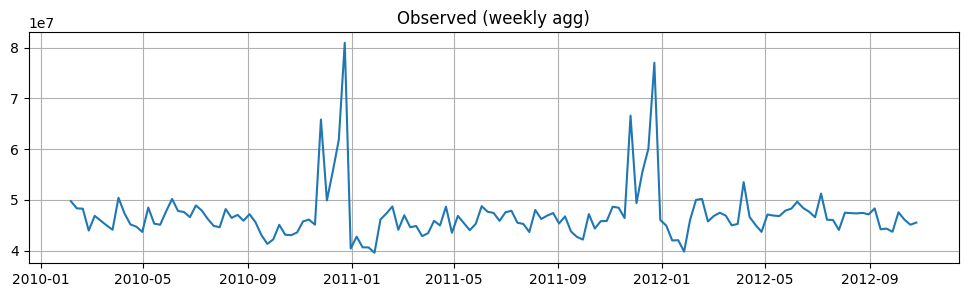

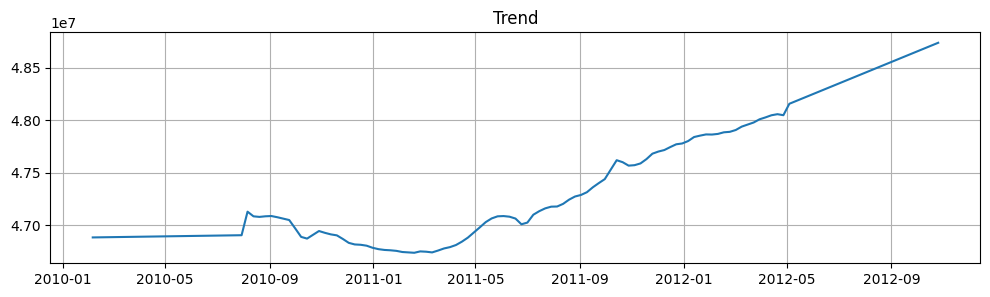

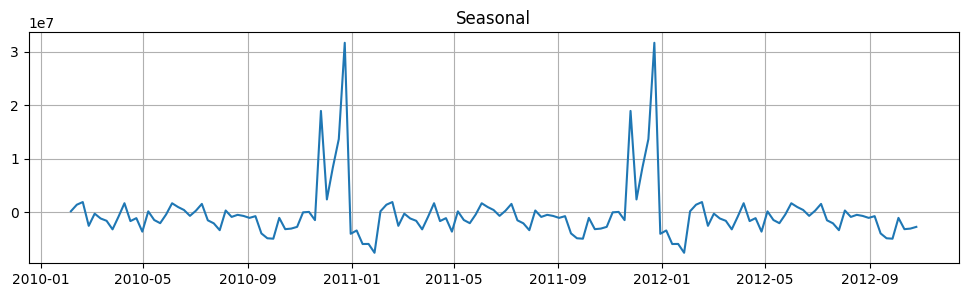

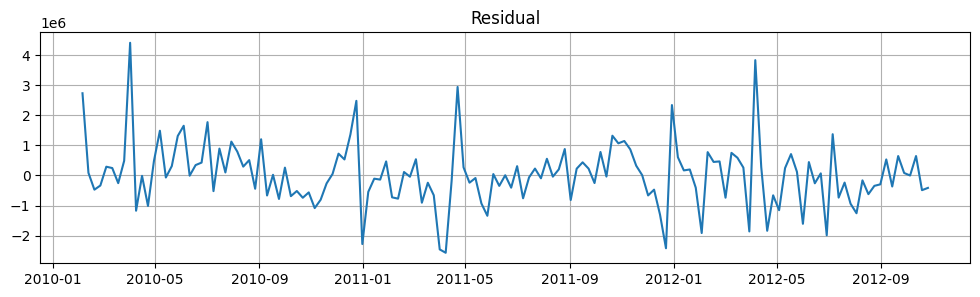

In [230]:
# Aggregate across all stores/depts to see seasonality
agg = train.groupby('Date')['Weekly_Sales'].sum().asfreq('W-FRI')
agg = agg.interpolate()  # fill small gaps if any
try:
    res = seasonal_decompose(agg, model='additive', period=52, extrapolate_trend='freq')
    plt.figure(figsize=(12,3)); plt.plot(res.observed); plt.title('Observed (weekly agg)'); plt.grid(True); plt.show()
    plt.figure(figsize=(12,3)); plt.plot(res.trend); plt.title('Trend'); plt.grid(True); plt.show()
    plt.figure(figsize=(12,3)); plt.plot(res.seasonal); plt.title('Seasonal'); plt.grid(True); plt.show()
    plt.figure(figsize=(12,3)); plt.plot(res.resid); plt.title('Residual'); plt.grid(True); plt.show()
except Exception as e:
    print("Seasonal decomposition skipped:", e)

## **7) Lag & Rolling Features (per Store-Dept)**

In [231]:
train = train.sort_values(['Store','Dept','Date']).reset_index(drop=True)
# create weekly lags
LAGS = [1,2,4,13]          # 1 week, 2 weeks, 4 weeks (~1 month), 13 weeks (~quarter)
ROLLS = [4,8,13,26]        # rolling windows in weeks

for lag in LAGS:
    train[f'lag_{lag}'] = train.groupby(['Store','Dept'])['Weekly_Sales'].shift(lag)

for w in ROLLS:
    # shift(1) so rolling mean uses past values only
    train[f'rollmean_{w}'] = train.groupby(['Store','Dept'])['Weekly_Sales'].shift(1).rolling(window=w, min_periods=1).mean()


In [232]:
# For test: to produce accurate lag/roll for test rows you'd normally append test rows with future dates,
# but for simplicity we will fill test later using last history per series if needed.

# Drop rows with NA in the largest lag (start of series)
train = train.dropna(subset=[f'lag_{max(LAGS)}']).reset_index(drop=True)


## **8) Ensure no object columns remain (encode categoricals)**

In [233]:
# Identify object columns
obj_cols = train.select_dtypes(include='object').columns.tolist()
print("Object columns (train):", obj_cols)


Object columns (train): ['Type']


In [234]:
# Typical object cols: 'Type' from stores, maybe others named differently. We'll encode all object columns.
encoders = {}
from sklearn.preprocessing import LabelEncoder
for col in obj_cols:
    le = LabelEncoder()
    # fit on union of train[col] + test[col] (if exists) to avoid unseen labels during test transform
    if col in test.columns:
        le.fit(pd.concat([train[col].astype(str), test[col].astype(str)], axis=0).unique())
        train[col] = le.transform(train[col].astype(str))
        test[col]  = le.transform(test[col].astype(str))
    else:
        le.fit(train[col].astype(str).unique())
        train[col] = le.transform(train[col].astype(str))
    encoders[col] = le
print("Encoded object cols:", list(encoders.keys()))

Encoded object cols: ['Type']


In [235]:
# Ensure IsHoliday is int (already done), and any remaining bool -> int
for df in (train, test):
    bool_cols = df.select_dtypes(include=['bool']).columns.tolist()
    for b in bool_cols:
        df[b] = df[b].astype(int)

# Final dtypes check
print(train.dtypes[train.dtypes == 'object'])  # should be empty


Series([], dtype: object)


## **9) Feature list & target**

In [236]:
# Choose features: time features + exogenous features from features.csv + lag/roll + store metadata
# We'll include common columns if they exist
base_features = ['Store','Dept','IsHoliday','Year','Month','Week','DayOfWeek']
exog = ['Temperature','Fuel_Price','CPI','Unemployment']   # these may exist with suffixes depending on merges
# find any MarkDown columns (starting with MarkDown)
markdowns = [c for c in train.columns if c.lower().startswith('markdown')]
lag_cols = [f'lag_{l}' for l in LAGS]
roll_cols = [f'rollmean_{w}' for w in ROLLS]


In [237]:
#assemble features present in train
features_to_use = []
for f in base_features + exog + markdowns + lag_cols + roll_cols + ['Type','Size']:
    if f in train.columns:
        features_to_use.append(f)

print("Final feature count:", len(features_to_use))
print(features_to_use[:80])

Final feature count: 26
['Store', 'Dept', 'IsHoliday', 'Year', 'Month', 'Week', 'DayOfWeek', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'lag_1', 'lag_2', 'lag_4', 'lag_13', 'rollmean_4', 'rollmean_8', 'rollmean_13', 'rollmean_26', 'Type', 'Size']


In [238]:
X_all = train[features_to_use].copy()
y_all = train['Weekly_Sales'].copy()


## **10) Time-aware split: last N weeks as validation**

In [239]:
VALID_WEEKS = 12
last_date = train['Date'].max()
cutoff = last_date - pd.Timedelta(weeks=VALID_WEEKS)
train_mask = train['Date'] <= cutoff
valid_mask = train['Date'] > cutoff

X_train = X_all[train_mask].copy()
y_train = y_all[train_mask].copy()
X_valid = X_all[valid_mask].copy()
y_valid = y_all[valid_mask].copy()

print("Train rows:", X_train.shape[0], "Valid rows:", X_valid.shape[0])


Train rows: 344350 Valid rows: 35470


In [240]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 344350 entries, 0 to 379807
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         344350 non-null  int64  
 1   Dept          344350 non-null  int64  
 2   IsHoliday     344350 non-null  int64  
 3   Year          344350 non-null  int32  
 4   Month         344350 non-null  int32  
 5   Week          344350 non-null  int32  
 6   DayOfWeek     344350 non-null  int32  
 7   Temperature   344350 non-null  float64
 8   Fuel_Price    344350 non-null  float64
 9   CPI           344350 non-null  float64
 10  Unemployment  344350 non-null  float64
 11  MarkDown1     114530 non-null  float64
 12  MarkDown2     90429 non-null   float64
 13  MarkDown3     103963 non-null  float64
 14  MarkDown4     102519 non-null  float64
 15  MarkDown5     115067 non-null  float64
 16  lag_1         344350 non-null  float64
 17  lag_2         344350 non-null  float64
 18  lag_4    

In [241]:
X_train = X_train.fillna(0)
X_valid = X_valid.fillna(0)

## **11) Baseline Models: Linear Regression & Random Forest**

## **Linear Regression**

In [242]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_valid)
mae_lr = mean_absolute_error(y_valid, pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_valid, pred_lr))
print("LinearRegression RMSE:", rmse_lr, "MAE:", mae_lr)


LinearRegression RMSE: 3333.6040083505923 MAE: 1711.7517541068903


## **Random Forest**

In [244]:
rf = RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_valid)
mae_rf = mean_absolute_error(y_valid, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_valid, pred_rf))
print("RandomForest RMSE:", rmse_rf, "MAE:", mae_rf)

RandomForest RMSE: 3145.6394739592306 MAE: 1430.4354990414436


## **Plot Actual vs Predicted (validation period) — aggregated or series-level**

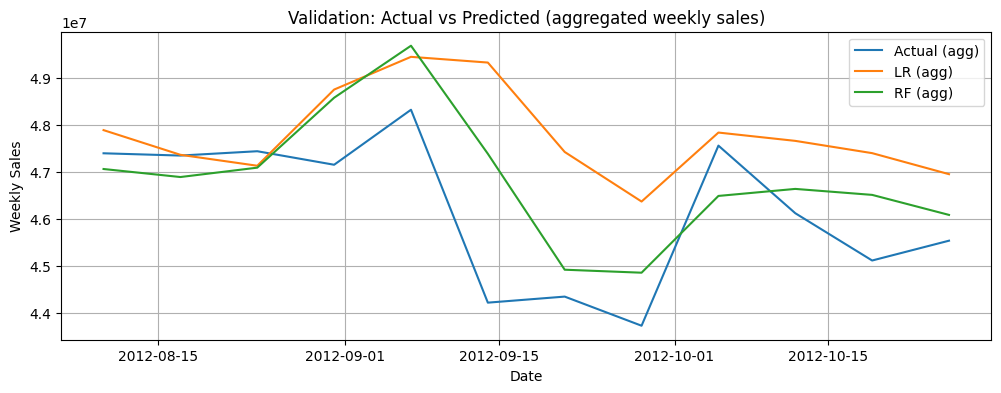

In [245]:
# We'll plot aggregated weekly actual vs predicted across all series
val_dates = train.loc[valid_mask, 'Date']
actual_agg = train.loc[valid_mask].groupby('Date')['Weekly_Sales'].sum()
pred_df = train.loc[valid_mask, ['Date']].copy()
pred_df['pred_lr'] = pred_lr
pred_df['pred_rf'] = pred_rf
pred_agg = pred_df.groupby('Date')[['pred_lr','pred_rf']].sum()

plt.figure(figsize=(12,4))
plt.plot(actual_agg.index, actual_agg.values, label='Actual (agg)')
plt.plot(pred_agg.index, pred_agg['pred_lr'].values, label='LR (agg)')
plt.plot(pred_agg.index, pred_agg['pred_rf'].values, label='RF (agg)')
plt.title('Validation: Actual vs Predicted (aggregated weekly sales)')
plt.xlabel('Date'); plt.ylabel('Weekly Sales'); plt.legend(); plt.grid(True); plt.show()


## **12) Bonus: Time-aware CV + XGBoost & LightGBM**

In [246]:
#    Use TimeSeriesSplit on training portion only for basic validation
tscv = TimeSeriesSplit(n_splits=3)
X_train_np = X_train.values
y_train_np = y_train.values



## **XGBoost**

In [252]:

xgb_model = xgb.XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, tree_method='hist')
xgb_model.fit(X_train_np, y_train_np)
pred_xgb = xgb_model.predict(X_valid.values)
rmse_xgb = np.sqrt(mean_squared_error(y_valid, pred_xgb))
print("XGBoost RMSE:", rmse_xgb)

XGBoost RMSE: 2755.430062011976


# **LightGBM**

In [253]:
lgb_model = lgb.LGBMRegressor(n_estimators=400, learning_rate=0.05, num_leaves=63, subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1)
lgb_model.fit(X_train_np, y_train_np)
pred_lgb = lgb_model.predict(X_valid.values)
rmse_lgb = np.sqrt(mean_squared_error(y_valid, pred_lgb))
print("LightGBM RMSE:", rmse_lgb)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.153023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4561
[LightGBM] [Info] Number of data points in the train set: 344350, number of used features: 25
[LightGBM] [Info] Start training from score 16199.614138


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM RMSE: 2720.6279914343468


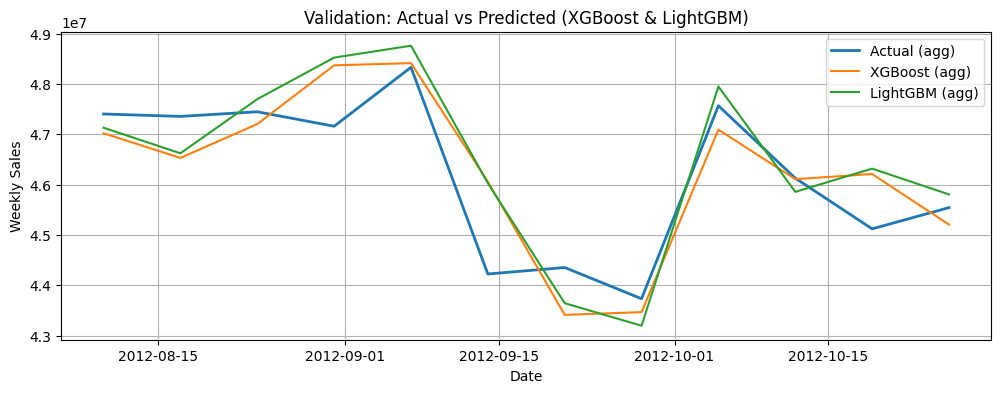

In [254]:
# Plot comparison aggregated
pred_df['pred_xgb'] = pred_xgb
pred_df['pred_lgb'] = pred_lgb
pred_agg2 = pred_df.groupby('Date')[['pred_lr','pred_rf','pred_xgb','pred_lgb']].sum()

plt.figure(figsize=(12,4))
plt.plot(actual_agg.index, actual_agg.values, label='Actual (agg)', linewidth=2)
plt.plot(pred_agg2.index, pred_agg2['pred_xgb'].values, label='XGBoost (agg)')
plt.plot(pred_agg2.index, pred_agg2['pred_lgb'].values, label='LightGBM (agg)')
plt.title('Validation: Actual vs Predicted (XGBoost & LightGBM)')
plt.xlabel('Date'); plt.ylabel('Weekly Sales'); plt.legend(); plt.grid(True); plt.show()
